# Student-teacher Knowledge Distillation for Keypoint extraction

In [ ]:
import sys
import os
import pathlib

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from transformers import AutoImageProcessor, SuperPointForKeypointDetection
from nw_code.datasets import SingleImageDataset
from nw_code.student_teacher import StudentTeacher
from nw_code.datasets import CocoDataloader

import pytorch_lightning as pl

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

ROOT = pathlib.Path("assets") / "coco"
IMAGES_PATH = str(ROOT / "images")
ANNOTATIONS__TRAIN_PATH = str(ROOT / "instances_train2014.json")
ANNOTATIONS__TRAIN_PATH = str(ROOT / "instances_val2014.json")

# Load teacher model
print("\n1. Loading teacher model (SuperPoint)...")
processor = AutoImageProcessor.from_pretrained(
    "magic-leap-community/superpoint",
    size={"height": 240, "width": 320}, do_rescale=True)
teacher = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
teacher.eval()
teacher_params = sum(p.numel() for p in teacher.parameters())
print(f"   ✓ Teacher loaded: {teacher_params:,} parameters")

# Create dataset
print("\n2. Creating single-image dataset...")
dataset = SingleImageDataset(processor, num_samples=200)
train_loader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)
print(f"   ✓ Dataset created: {len(dataset)} samples")

# Create Lightning module
print("\n3. Creating student model...")
model = StudentTeacher(teacher, dataset, lr=LEARNING_RATE)
student_params = sum(p.numel() for p in model.student.parameters())
print(f"   ✓ Student created: {student_params:,} parameters")
print(f"   ✓ Compression ratio: {teacher_params / student_params:.1f}x smaller")

# Training
print("\n4. Training student to mimic teacher...")
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator='auto',
    devices=1,
    precision='16-mixed',
    log_every_n_steps=5,
    enable_checkpointing=False,
    enable_progress_bar=True,
)
torch.set_float32_matmul_precision('medium')

# trainer.fit(model, train_loader, val_loader)

# Visualize results
print("\n5. Generating visualizations...")

# Save model
# torch.save(model.student.state_dict(), '/mnt/user-data/outputs/tiny_student.pth')

print("\n" + "=" * 70)
print("Training complete!")
print("=" * 70)


1. Loading teacher model (SuperPoint)...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


   ✓ Teacher loaded: 1,300,865 parameters

2. Creating single-image dataset...
   ✓ Dataset created: 200 samples

3. Creating student model...
   ✓ Student created: 75,137 parameters
   ✓ Compression ratio: 17.3x smaller

4. Training student to mimic teacher...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



5. Generating visualizations...

Training complete!


/home/tordna/tiny-deep-feature-extraction/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/tordna/tiny-deep-feature-extraction/.venv/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be de

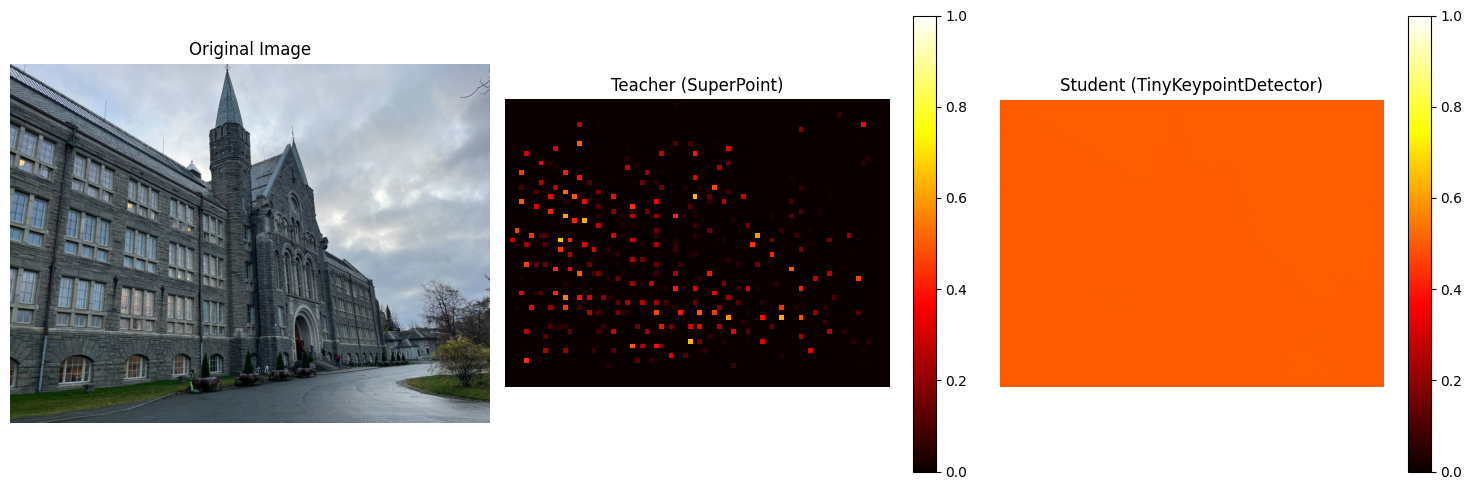

In [5]:
from nw_code.visualization import visualize_results

fig = visualize_results(model, dataset.image, processor)


In [ ]:


dataset = CocoDataloader(IMAGES_PATH, ANNOTATIONS_PATH, processor=processor)

sample = dataset[0]
print(f"{type(sample) = }")

loading annotations into memory...
Done (t=8.97s)
creating index...
index created!
type(sample) = <class 'torch.Tensor'>
